<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Tarea Semanal Nº9
#### Tobías Guerrero

## 1. Introducción

En este trabajo semanal, se propone diseñar dos filtros digitales, uno IIR y otro FIR, para filtrar la señal de ECG estimada en la tarea semanal anterior. Para esto, y también basándose en el análisis realizado en la tarea semanal anterior, se propone la siguiente plantilla:

- $ \omega_{s_{1}} = 0.1 $
- $ \omega_{p_{1}} = 0.5 $
- $ \omega_{p_{2}} = 30 $
- $ \omega_{s_{2}} = 40 $

## 2. Variables y señal de ECG

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from pytc2.sistemas_lineales import plot_plantilla
import scipy.io as io
import warnings
warnings.filterwarnings('ignore')

coef = 3001
den_fir = 1.0

ripple = 0.1
atenuacion = 40

fs = 1000
nyq = 500
ws1 = 0.1
wp1 = 0.5
wp2 = 30.0
ws2 = 40.0

ws = np.array([ws1 , ws2])
wp = np.array([wp1 , wp2])

mat_struct = io.loadmat('ecg.mat')
ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
#ecg_one_lead = ecg_one_lead[10000:11000]
cant_muestras = len(ecg_one_lead)

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

frecs = np.array([0.0 , ws1 , wp1 , wp2 , ws2 , nyq])
gains = np.array([-atenuacion,-atenuacion,-ripple,-ripple,-atenuacion,-atenuacion])
gains = 10**(gains/20)

###########################

#### Aplico el filtro ####

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
)

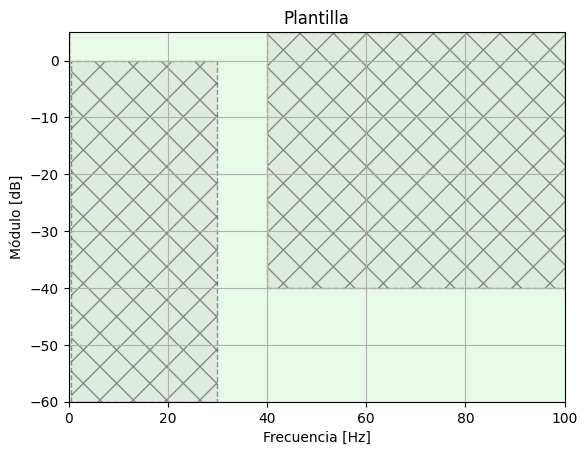

In [2]:
plt.title("Plantilla")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Módulo [dB]")
plt.grid()
plt.axis([0, 100, -60, 5])

plot_plantilla(filter_type = 'bandpass' , fpass = wp , ripple = ripple , fstop = ws , attenuation = atenuacion, fs = fs)

## 3. Diseño y filtrado con filtro FIR

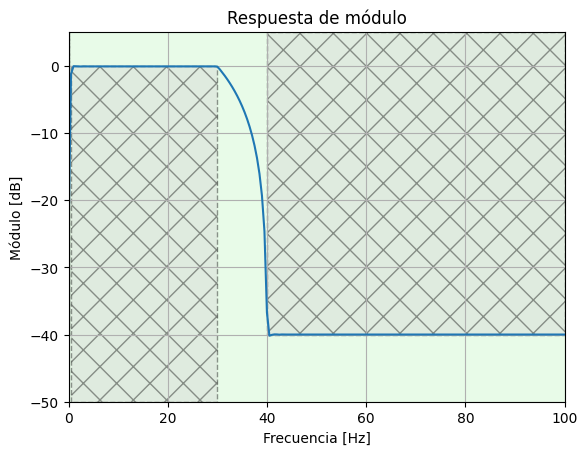

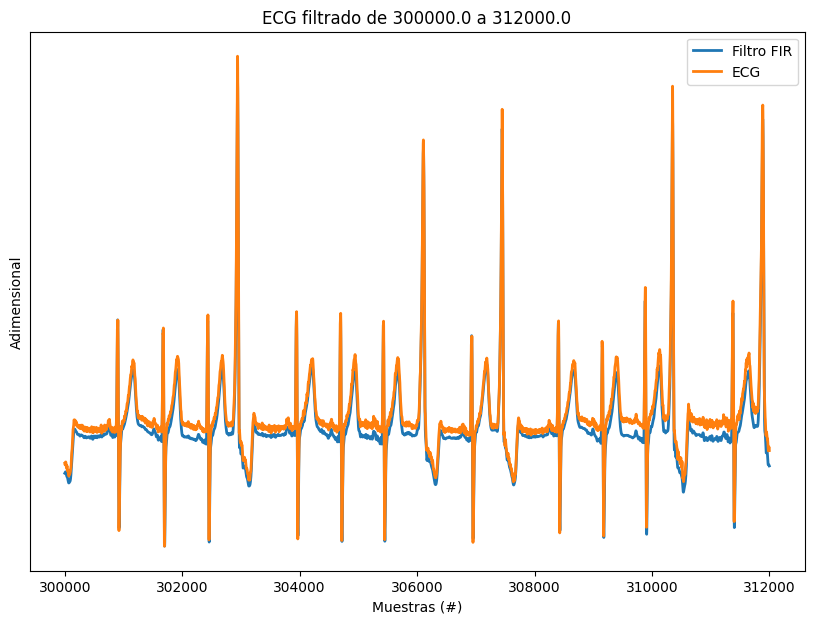

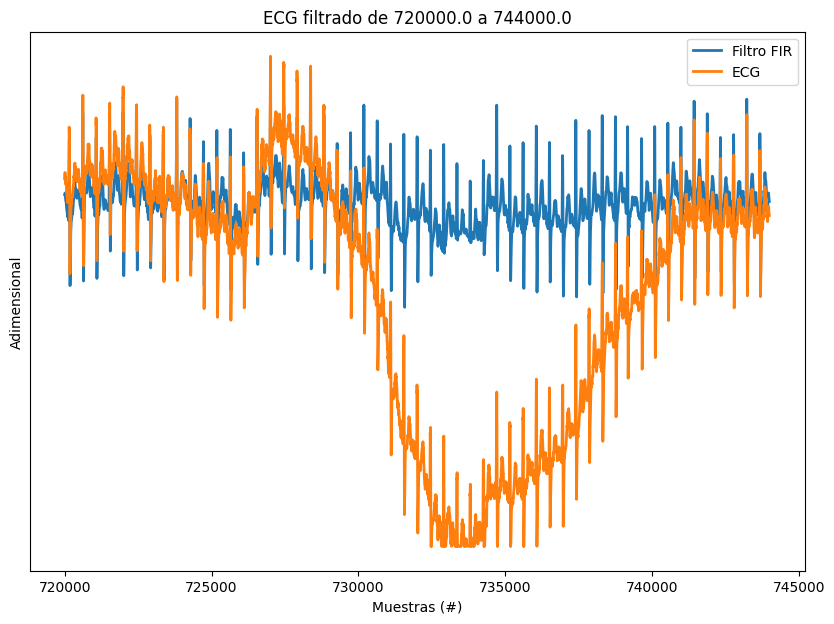

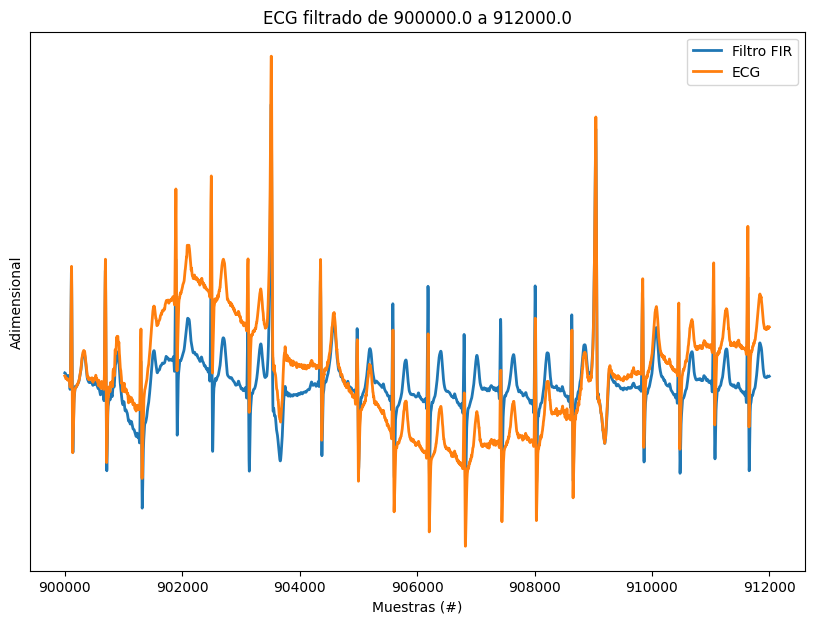

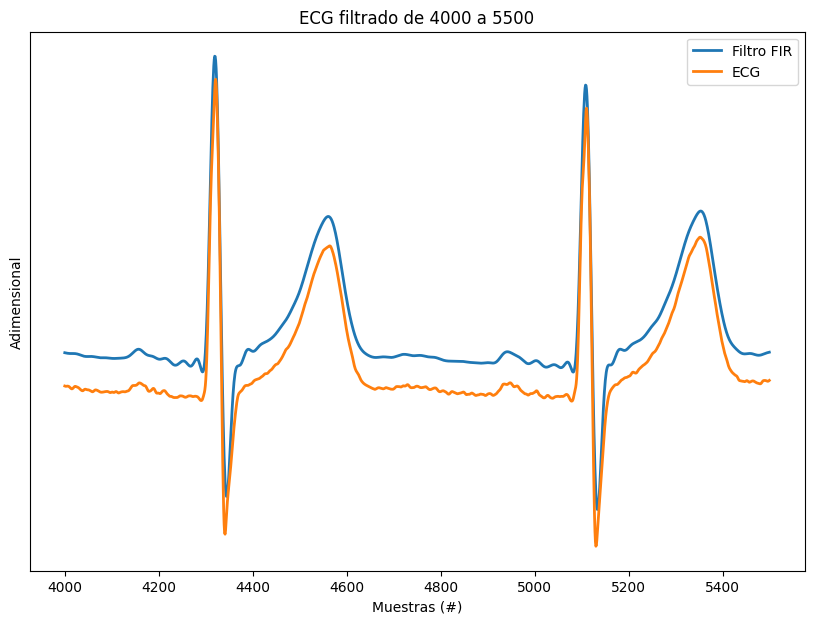

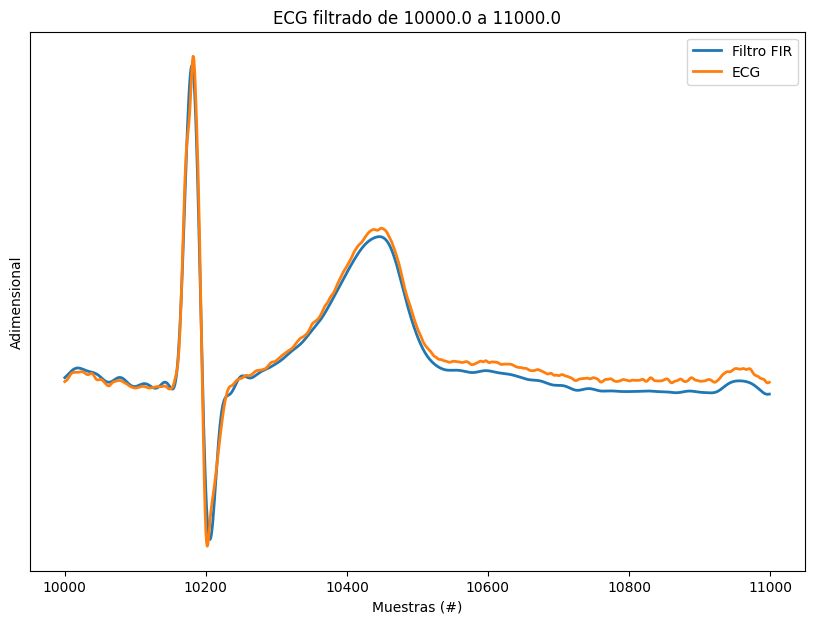

In [3]:
taps = signal.firwin2(coef , frecs , gains , window = 'tukey' , fs = fs)

ECG_fir = signal.lfilter(taps, den_fir, ecg_one_lead)

w_fir, h_fir = signal.freqz(taps, den_fir, worN=1000)

ww_fir = w_fir / np.pi * nyq

demora_fir = int((coef - 1) / 2)

plt.title("Respuesta de módulo")
plt.plot(ww_fir , 20*np.log10(abs(h_fir)))
plt.ylabel("Módulo [dB]")
plt.xlabel("Frecuencia [Hz]")
plt.grid()
plt.axis([0,100,-50,5])
plot_plantilla(filter_type = 'bandpass' , fpass = wp , ripple = ripple , fstop = ws , attenuation = atenuacion, fs = fs)

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ECG_fir[zoom_region + demora_fir], label='Filtro FIR', linewidth=2)
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_iir[zoom_region], label='Filtro IIR')
    #plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='Win')
    
    plt.title('ECG filtrado de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## 4. Diseño de filtro IIR

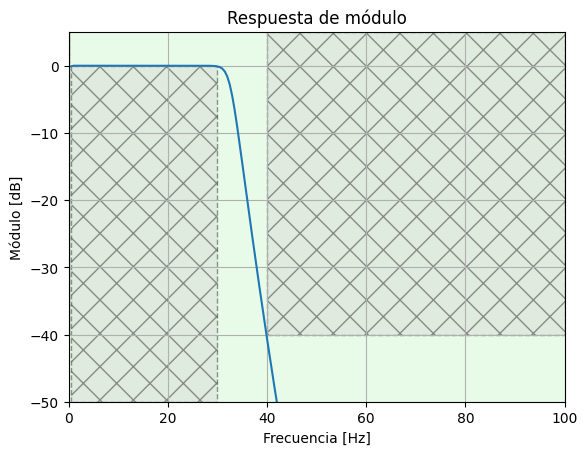

In [4]:
num , den = signal.iirdesign(wp , ws , ripple , atenuacion, ftype = "butter", output = 'ba', fs = fs)

sos = signal.iirdesign(wp , ws , ripple , atenuacion, ftype = "butter", output = 'sos', fs = fs)

w_iir, h_iir = signal.sosfreqz(sos, worN=1000)

ww_iir = w_iir / np.pi * nyq

modulo_iir = plt.figure()
plt.title("Respuesta de módulo")
plt.plot(ww_iir , 20*np.log10(abs(h_iir)))
plt.ylabel("Módulo [dB]")
plt.xlabel("Frecuencia [Hz]")
plt.grid()
plt.axis([0,100,-50,5])
plot_plantilla(filter_type = 'bandpass' , fpass = wp , ripple = ripple , fstop = ws , attenuation = atenuacion, fs = fs)

### 4.1 Filtrado con IIR y desfasaje manual

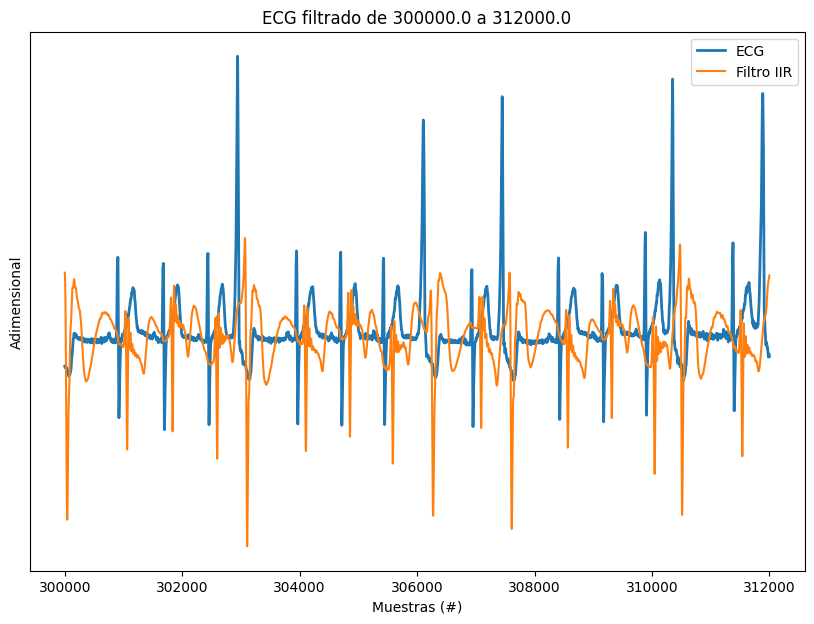

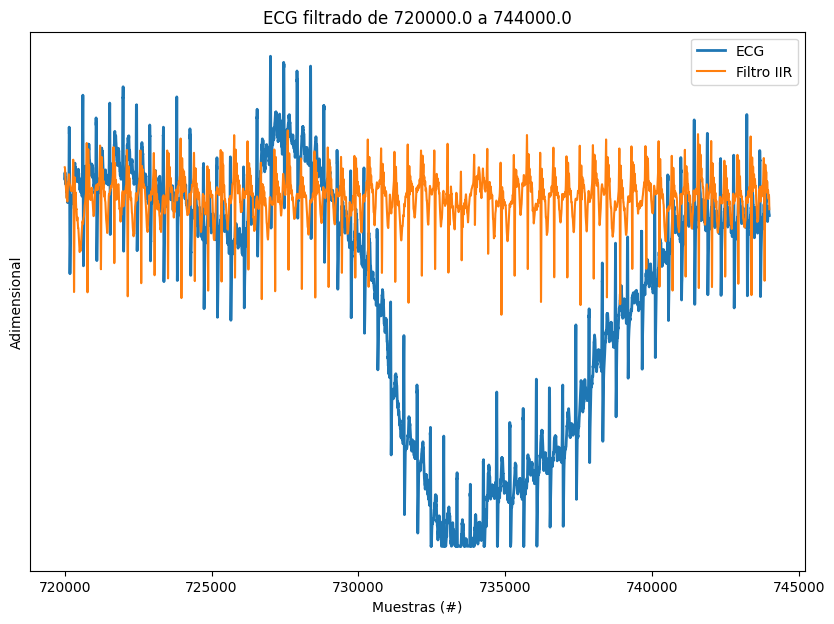

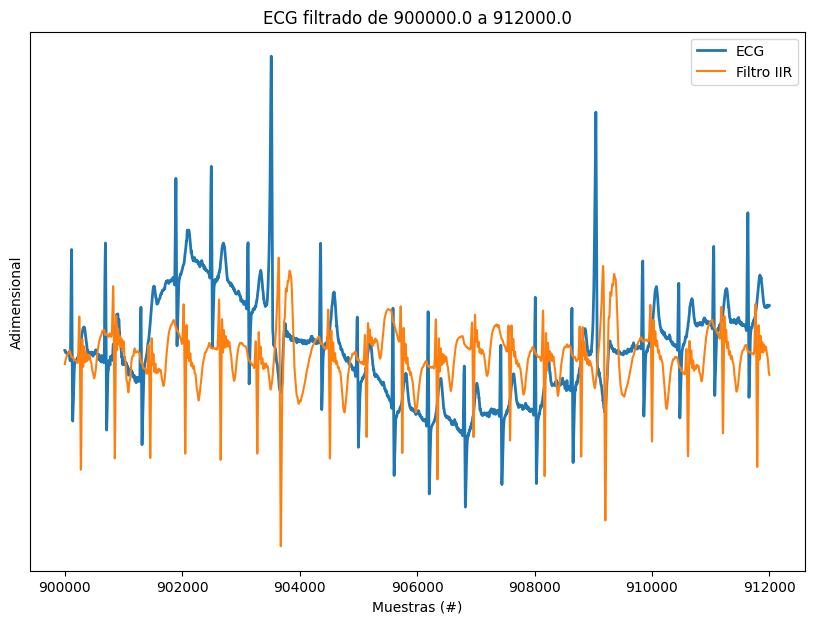

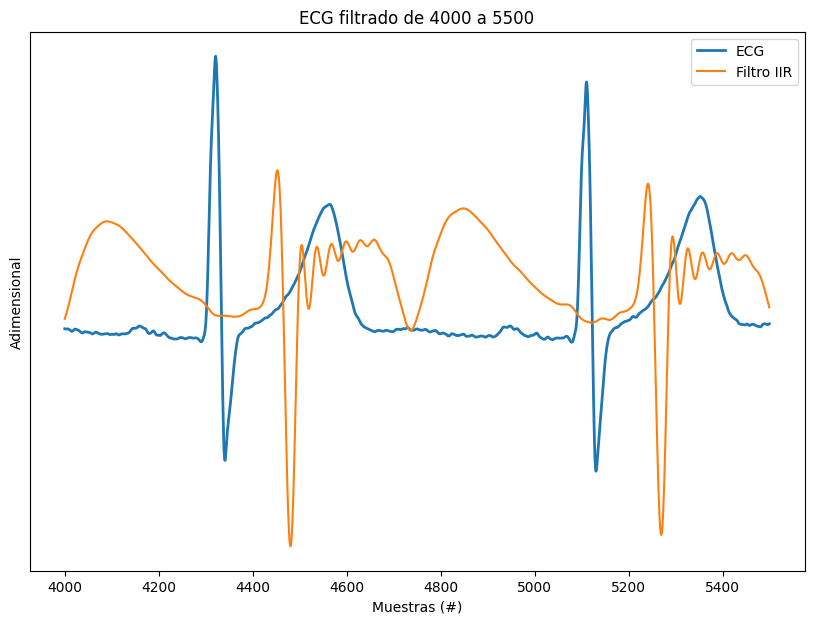

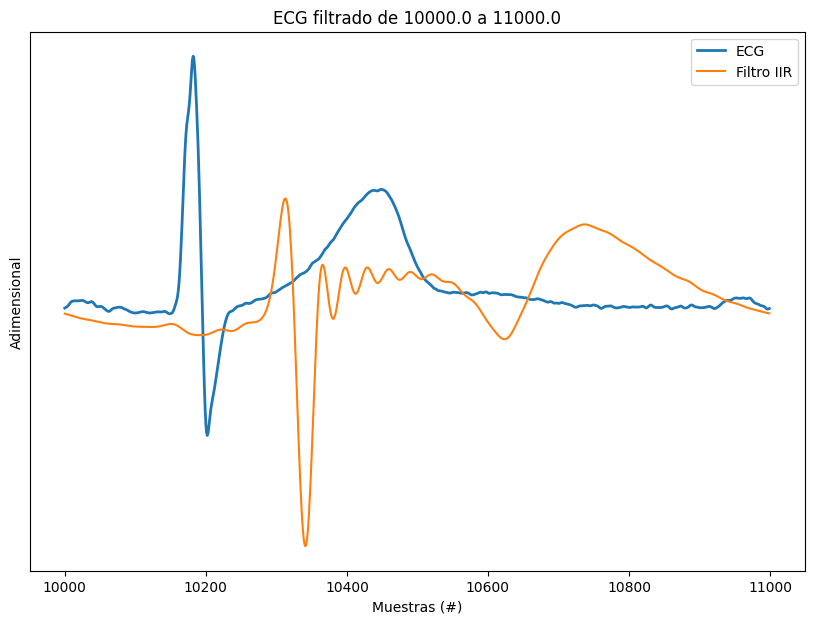

In [5]:
ECG_f_iir = signal.sosfilt(sos, ecg_one_lead)

demora = -64 # Calculado a ojo

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_iir[zoom_region + demora], label='Filtro IIR')
    
    plt.title('ECG filtrado de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

### 4.2 Filtrado bilineal con IIR

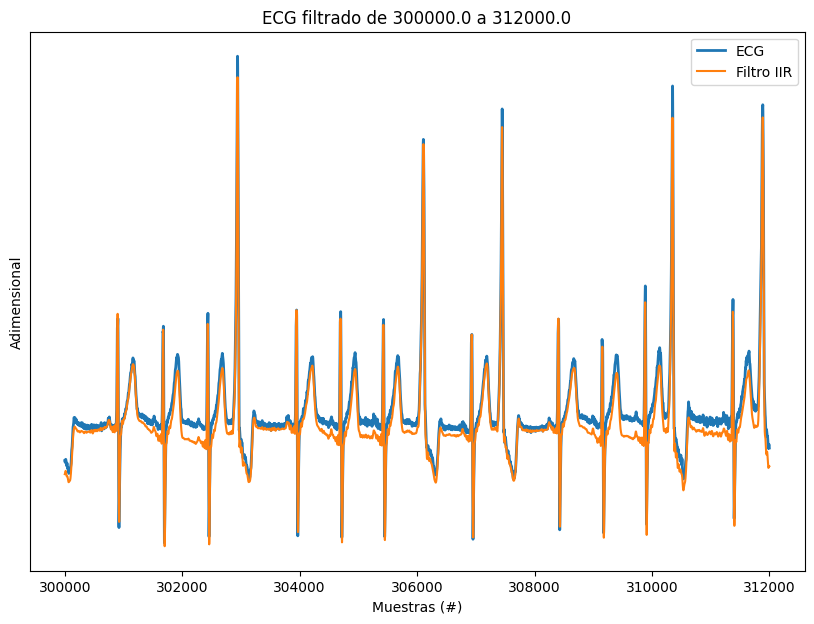

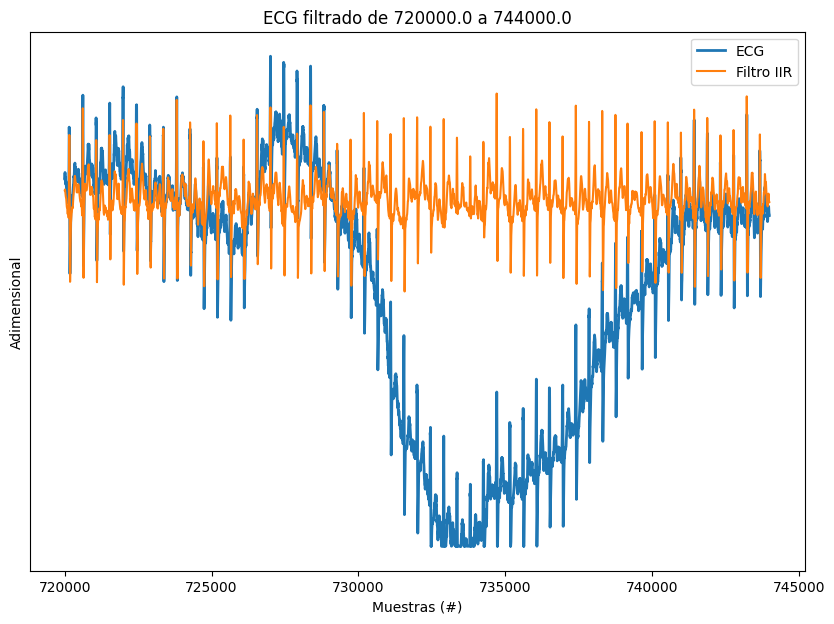

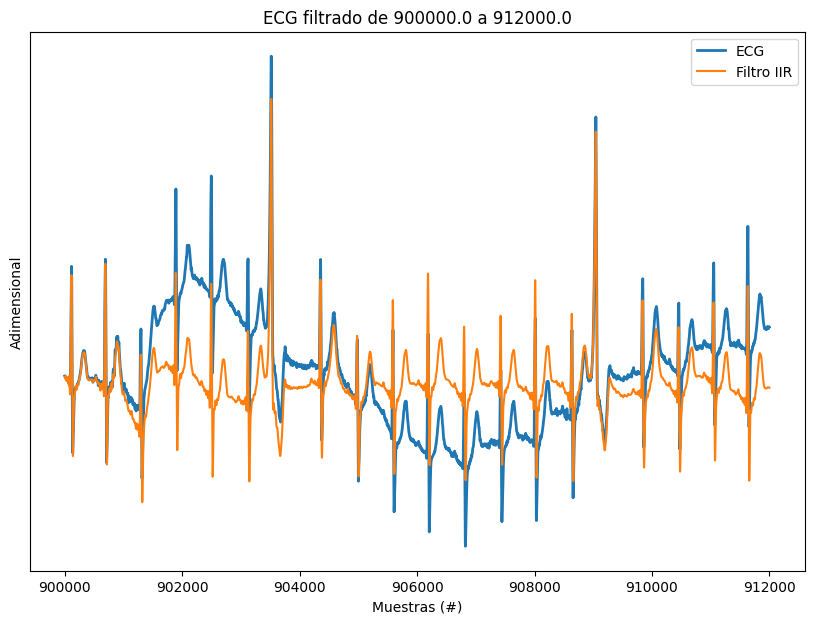

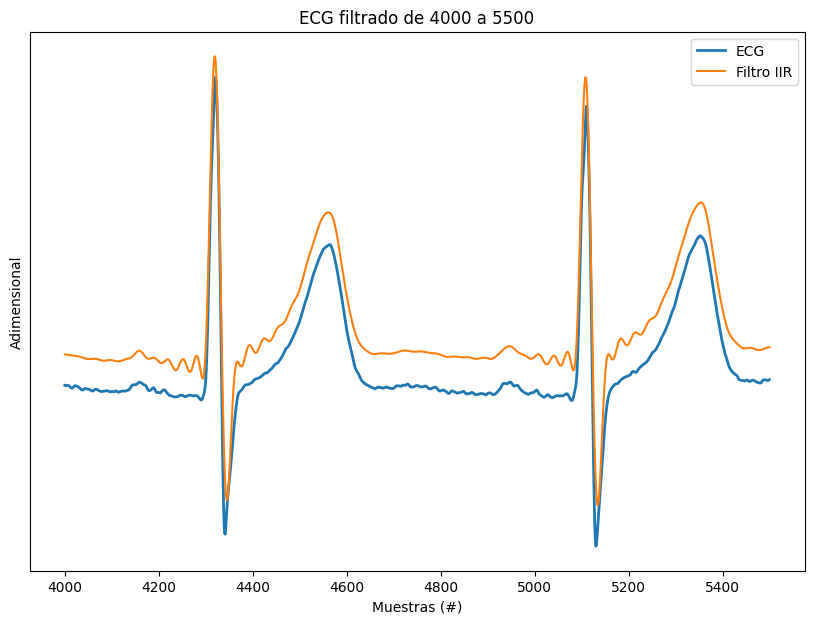

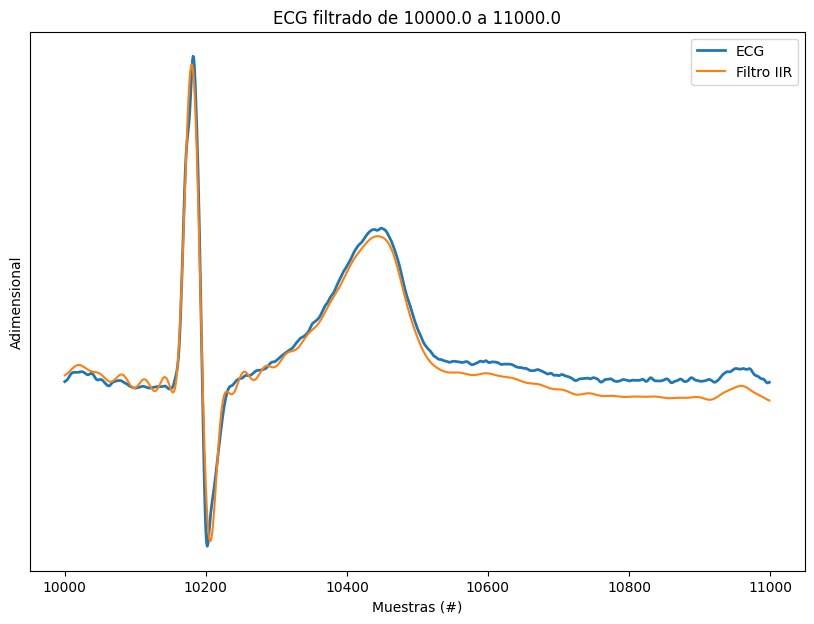

In [6]:
ECG_bil = signal.sosfiltfilt(sos, ecg_one_lead)

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_bil[zoom_region], label='Filtro IIR')
    
    plt.title('ECG filtrado de ' + str(ii[0]) + ' a ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## 5. Conclusiones

Se observó que ambos métodos son útiles a la hora de filtrar digitalmente una señal, logrando separar las distintas componetes para un mejor análisis. 

Se aprecia una mayor dificultad computacional en la implementación del filtro IIR, debido a tener mayor cantidad de componentes. Además, resulta prácticamente obligatorio realizar este filtrado de forma bilineal, para así evitar tener distorsión de fase.